In [1]:
import os
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [3]:
base_model_name = 'inception' 
base_model = tf.keras.models.load_model(f'model/{base_model_name}')

In [4]:
local_model = tf.keras.Model(inputs=base_model.inputs, 
                             outputs=base_model.get_layer(name = 'mixed0').output, 
                             name="local_feature")

In [5]:
global_model = tf.keras.Model(inputs = base_model.inputs, 
                             outputs=base_model.get_layer(name = 'global_average_pooling2d').output,
                             name = 'global_feature')

In [6]:
def get_class_label_weight(df):
    labels = list(df['dx'])
    
    weights = compute_class_weight(class_weight = 'balanced', 
                         classes = np.unique(labels),
                         y = labels)

    labels = np.unique(labels)

    class_label = {name : idx for idx, name in enumerate(labels)}
    weights = {idx : weights[idx] for idx, name in enumerate(labels)}
    
    return class_label, weights

In [7]:
def get_img(img_path, image_size=299):
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    img = tf.keras.preprocessing.image.load_img(img_path, 
                                                target_size = (image_size,image_size))
    img = tf.keras.utils.img_to_array(img) 
    img = preprocess_input(img)
    return img

In [8]:
train_df = pd.read_csv('data/train_truth.csv')

In [9]:
class_label, weights = get_class_label_weight(train_df)

In [10]:
shuffle_df = lambda x : x.sample(frac=1) 

In [11]:
def get_local_feature(df, label, num = 5):
    img_id = df[df['dx'] == label]
    img_id = df.sample(num)[['image_id','dx']]
    l = []
    for row in img_id.iterrows():
        row = row[1]
        path = f'data/train/{row["dx"]}/{row["image_id"]}.jpg'
        l.append(get_img(path))
    return np.array(l)

In [12]:
class Causal_Model(tf.keras.Model):
    def __init__(self, num_classes=7, class_weights=None):
        super().__init__()

        # Class Weight
        self.class_weights = class_weights 
        
        # Pooling for local features for each image
        self.pooled = tf.keras.layers.GlobalAveragePooling2D()

        # Post-Concatenation
        self.dense_1 = tf.keras.layers.Dense(1024, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(1024, activation='relu')

        # Prediction Layer
        self.prediction = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, global_feature, local_feature):
        local_feature = self.pooled(local_feature)
        x = tf.concat([global_feature, local_feature], 1)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.prediction(x)
        return tf.math.reduce_mean(x, axis = 0)
    
    def build_graph(self, local_feature_shape = (35, 35, 256), global_feature_shape = (2048)):
        local_feature = tf.keras.layers.Input(shape = local_feature_shape, dtype='float32')
        global_feature = tf.keras.layers.Input(shape = global_feature_shape)
        
        return tf.keras.Model(inputs=[global_feature, local_feature], 
                              outputs=self.call(global_feature, local_feature))

In [13]:
cm = Causal_Model()
cm.build_graph().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35, 35, 256  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 global_average_pooling2d (Glob  (None, 256)         0           ['input_1[0][0]']                
 alAveragePooling2D)                                                                              
                                                                                              

In [14]:
retrain = True
model_name = 'causal'
if retrain and model_name in os.listdir('model'):
    model_weights = tf.keras.models.load_model(f'model/{model_name}')
    cm.set_weights(model_weights.get_weights()) 
    print('loaded previous model weights...')
cm.build_graph().summary()

loaded previous model weights...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35, 35, 256  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 global_average_pooling2d (Glob  (None, 256)         0           ['input_3[0][0]']                
 alAveragePooling2D)                                                                              
                                                           

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)

In [16]:
@tf.function
def loss_model(model, global_feature, local_feature, y, class_weight, training=False):
    y_pred = model(global_feature, local_feature, training=training)
    loss = loss_object(y, y_pred, sample_weight=class_weight)
    return loss

@tf.function
def grad_cm(model, global_feature, local_feature, y, class_weight):
    with tf.GradientTape() as tape:
        loss_value = loss_model(model, global_feature, local_feature, y, class_weight, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [17]:
def get_test_local_feature(df, folder,  num = 5):
    img_id = df.sample(num)['image_id']
    l = []
    for img in img_id:
        path = f'data/{folder}/{img}.jpg'
        l.append(get_img(path))
    return np.array(l)

In [18]:
def repeat_tensor(arr, repeat):
    return tf.repeat(arr, repeats = repeat, axis = 0)

In [19]:
def get_val_acc(cm, test_df, folder, end = " ", num = 5):

    acc = 0
    y_true, y_pred = [], []

    for row in test_df.iterrows():
        row = row[1]

        img_path = row['image_id']
        img = get_img(f'data/{folder}/{img_path}.jpg').reshape(-1, 299,299, 3)

        label = class_label[row['dx']]

        global_feature = global_model(img)
        global_feature = repeat_tensor(global_feature, [num])

        local_feature = local_model(get_test_local_feature(test_df, folder, num = num))
        pred = np.argmax(cm(global_feature, local_feature))    

        y_true.append(label)
        y_pred.append(pred)

        if pred == label:
            acc += 1

    print('[Acc] : ', (acc/len(test_df)), end = end)

In [20]:
val_df = pd.read_csv('data/val_truth.csv')

In [21]:
epochs = range(11)
num = 15

In [ ]:
for epoch in tqdm(epochs, desc='Epochs'):
    loss, steps = 0, 0 
    df = shuffle_df(train_df)
    t1 = time.time()
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        
        img_id = row['image_id']
        label = row['dx']
        
        img_path = f'data/train/{label}/{img_id}.jpg'
        img = get_img(img_path).reshape(-1, 299,299, 3)
        
        global_feature = global_model(img)
        global_feature = repeat_tensor(global_feature, [num])
        
        local_feature = local_model(get_local_feature(train_df, label, num = num))
        
        label_idx = np.array([class_label[label]])        
        weight = np.array([weights[label_idx[0]]])

        loss_value, grads = grad_cm(cm, global_feature, local_feature, label_idx, weight)
        optimizer.apply_gradients(zip(grads, cm.trainable_weights))   
        
        loss += loss_value.numpy()
        steps += 1
    
    print(f"[{epoch}] Loss : {loss/steps}", end = " ")
    
    if epoch > 0 and epoch % 2 == 0 :
        cm.save('model/causal')
    if epoch % 1 == 0:
        get_val_acc(cm, val_df, 'val')
    print(f"[Time] : {time.time() - t1} sec")

  0%|          | 0/1001 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       akiec       0.54      0.71      0.61        31
         bcc       0.81      0.81      0.81        54
         bkl       0.70      0.67      0.68       117
          df       1.00      0.36      0.53        14
         mel       0.55      0.71      0.62       103
          nv       0.94      0.90      0.92       663
        vasc       0.95      0.95      0.95        19

    accuracy                           0.84      1001
   macro avg       0.78      0.73      0.73      1001
weighted avg       0.85      0.84      0.84      1001



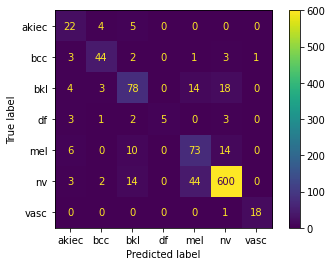

In [25]:
test_df = pd.read_csv('data/test_truth.csv')
y_true, y_pred = [], []

pred_num = 15

for _, row in tqdm(test_df.iterrows(), total = len(test_df)):    
    img_path = row['image_id']
    img = get_img(f'data/test/{img_path}.jpg').reshape(-1, 299,299, 3)

    label = class_label[row['dx']]
    
    global_feature = global_model(img)
    global_feature = repeat_tensor(global_feature, [pred_num])
    
    local_feature = local_model(get_test_local_feature(test_df, "test", num = pred_num))
    pred = np.argmax(cm(global_feature, local_feature))    
    
    y_true.append(label)
    y_pred.append(pred)

print(classification_report(y_true, y_pred, target_names=class_label))

matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels = list(class_label.keys()))
disp.plot()

In [ ]:
def get_train_acc(train_df, cm, num=15):
    acc = 0
    for row in tqdm(train_df.iterrows(), total=len(train_df)):
        row = row[1]

        img_path = row['image_id']
        label = row['dx']

        img = get_img(f'data/train/{label}/{img_path}.jpg').reshape(-1, 299,299, 3)

        global_feature = global_model(img)
        global_feature = repeat_tensor(global_feature, [num])

        local_feature = local_model(get_local_feature(train_df, row["dx"]))
        pred = np.argmax(cm(global_feature, local_feature))    

        if pred == class_label[label]:
            acc += 1

    print('Acc : ', (acc/len(train_df)))

In [ ]:
#get_train_acc(train_df, cm, num=5)